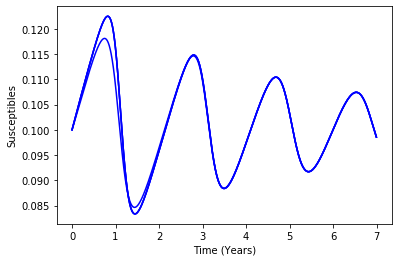

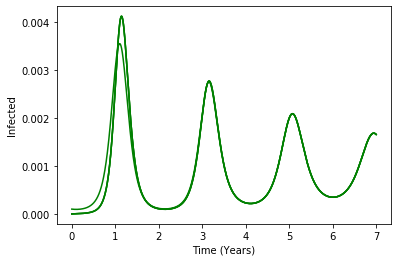

In [5]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pylab as plt

# Number of sub-populations
n = 4

beta = 1.0*np.ones(n)
gamma = 0.1*np.ones(n)
nu = 0.0001*np.ones(n)
mu = 0.0001*np.ones(n)
X0 = 0.1*np.ones(n)
Y0=0.0*np.ones(n)
Y0[0]=0.0001
m = 0.001*np.ones((n,n))
m = m - np.diag(np.diag(m))
ND = 7 * 365

def diff_eqs(INP,t):  
    """
    Main set of equations in the SIR model with metapopulations. 
    """

    Y = np.zeros((2*n))
    V = INP   

    for i in range(n):
        Y[i] = nu[i] - beta[i]*V[i]*V[n+i] - mu[i]*V[i]; 
        Y[n+i] = beta[i]*V[i]*V[n+i] - mu[i]*V[n+i] - gamma[i]*V[n+i]

        for j in range(n):
            Y[i] += m[i][j]*V[j] - m[j][i]*V[i];
            Y[n+i] += m[i][j]*V[n+j] - m[j][i]*V[n+i];
    return Y

t_range = np.arange(0, ND, 1)
solution = spi.odeint(diff_eqs, np.hstack((X0,Y0)), t_range)


for i in range(n):
    plt.plot(t_range/365.0, solution[:,i], color='blue')
plt.xlabel('Time (Years)')
plt.ylabel('Susceptibles')
plt.show()

for i in range(n):
    plt.plot(t_range/365.0, solution[:,i+n], color='g')
plt.ylabel('Infected')
plt.xlabel('Time (Years)')
plt.show()




